<a href="https://colab.research.google.com/github/Sadie-Zhao/Fisher-Markets-with-Social-Influence-AAAI23/blob/main/Influence_Fisher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 12.8 MB/s 


In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc
import random


rc('animation', html='jshtml')

# Set up

In [ ]:
def get_neighborsets(num_buyers):
  neighborsets = []
  for buyer in range(num_buyers):
    neighborsets.append([random.randint(0, 1) for _ in range(num_buyers)])
    neighborsets[buyer][buyer] = 1
  print(neighborsets)
  return np.array(neighborsets)

In [ ]:
############# Important Utility Function Definitions #############

# Linear utility function: Perfect Substitutes
def get_linear_utility(allocation, valuations):
    # Returns utility value for linear agent
    return allocation.T @ valuations

# Leontief utility function: Perfect Complements
def get_leontief_utility(allocation, valuations):
    return np.min(allocation/valuations)

# Cobb-Douglas utility function
def get_cd_utility(allocation, valuations):
    # For easy of calculation, normalize valautions
    # This does not change the preference relation that the utility function represents
    normalized_vals = valuations / np.sum(valuations)
    return np.prod(np.power(allocation, normalized_vals))

# obj functions

def get_linear_obj(prices, demands, budgets, valuations, neighborsets):
    num_buyers = demands.shape[0]
    utils = np.sum(valuations*demands, axis = 1)
    true_utils = np.array([0.0,0.0,0.0])
    for buyer in range(num_buyers):
      true_utils[buyer] = np.sum([utils[n] for n in range(num_buyers) if neighborsets[buyer][n]==1])
    return np.sum(prices) - (num_buyers-1)/(num_buyers)* np.sum([demands[buyer].T @ prices for buyer in range(num_buyers)]) + 1/(num_buyers)* budgets.T @ np.log(true_utils)

def get_cd_obj(prices, demands, budgets, valuations, neighborsets):
    num_buyers = demands.shape[0]
    utils = np.array([get_cd_utility(demands[i], valuations[i]) for i in range(num_buyers)])
    true_utils = np.array([0.0,0.0,0.0])
    for buyer in range(num_buyers):
      true_utils[buyer] = np.prod([utils[n] for n in range(num_buyers) if neighborsets[buyer][n]==1])
    # print("util:", utils)
    # print("true util:", true_utils)
    # print("-------------------------------------------------")
    return np.sum(prices) - (num_buyers-1)/(num_buyers)* np.sum([demands[buyer].T @ prices for buyer in range(num_buyers)]) + 1/(num_buyers)* budgets.T @ np.log(true_utils)

def get_leontief_obj(prices, demands, budgets, valuations, neighborsets):
    num_buyers = demands.shape[0]
    utils = np.min(demands/valuations, axis = 1)
    true_utils = np.array([0.0,0.0,0.0])
    for buyer in range(num_buyers):
      true_utils[buyer] = np.min([utils[n] for n in range(num_buyers) if neighborsets[buyer][n]==1])
    return np.sum(prices) - (num_buyers-1)/(num_buyers)* np.sum([demands[buyer].T @ prices for buyer in range(num_buyers)]) + 1/(num_buyers)* budgets.T @ np.log(true_utils)


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    normalized_vals = valuations / np.sum(valuations)
    return ( np.prod(np.power(allocations, normalized_vals))*( normalized_vals / allocations.clip(min = 0.001) ).T).T
    # return ( valuations / allocations.clip(min = 0.001) )

In [ ]:
def project_to_bugdet_set(X, p, b):
    X_prec = X
    while (True): 
        X -= ((X @ p - b).clip(min= 0)/(np.linalg.norm(p)**2).clip(min= 0.01) * np.tile(p, reps = (b.shape[0], 1)).T).T
        X = X.clip(min = 0)
        if(np.linalg.norm(X - X_prec) <= np.sum(X_prec)*0.05):
            break
        # print(f"Current iterate {X}\nPrevious Iterate {X_prec}")
        X_prec = X
    return X

# NE oracle

## Linear

In [ ]:
def ne_oracle_linear(prices, valuations, budgets, num_iters, learn_rate, neighborsets):
  demands_hist = []
  temp_demands = np.zeros(valuations.shape)
  demands = np.zeros(valuations.shape)
  for iter in range(num_iters):
    # # 
    # for buyer in range(3):
    #   temp_demands[buyer] = demands[buyer] + learn_rate * valuations[buyer]
    # temp_demands = project_to_bugdet_set(temp_demands, prices, budgets)
    #
    for buyer in range(3):
      demands[buyer] += learn_rate * valuations[buyer]
    demands = project_to_bugdet_set(demands, prices, budgets)
    demands = demands.clip(0.001)
    
    demands_hist.append(np.copy(demands))
  return demands, demands_hist


## Leontief

In [ ]:
demands = np.array([[1,1,1],[2,2,2], [3,3,3]])

In [ ]:
def get_leontief_grad(allocations, valuations, neighborsets):
  num_buyers = valuations.shape[0]
  mins = np.min(allocations/valuations.clip(min = 0.001), axis = 0)
  argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
  marginal_utils = np.zeros(allocations.shape)
  for buyer in range(num_buyers):
    temp_mins = np.array([mins[i]+(1-neighborsets[buyer][i])*1e10 for i in range(num_buyers)])
    if np.argmin(temp_mins) == buyer:
      marginal_utils[buyer, argmins[buyer]] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)

  return marginal_utils

In [ ]:
def ne_oracle_leontief(prices, valuations, budgets, num_iters, learn_rate, neighborsets):
  demands_hist = []
  temp_demands = np.zeros(valuations.shape).clip(min=0.1)
  demands = np.zeros(valuations.shape).clip(min=0.1)
  for iter in range(num_iters):
    # 
    temp_demands = demands + learn_rate * get_leontief_grad(demands, valuations, neighborsets)
    temp_demands = project_to_bugdet_set(temp_demands, prices, budgets)
    # temp_demands = temp_demands.clip(min=0.001)
    # 
    demands = demands + learn_rate * get_leontief_grad(temp_demands, valuations, neighborsets)
    demands = project_to_bugdet_set(demands, prices, budgets)
    demands = demands.clip(min=0.001)

    #
    demands_hist.append(np.copy(demands))
  return demands, demands_hist


## CD

In [ ]:
def ne_oracle_cd(prices, valuations, budgets, num_iters, learn_rate, neighborsets):
  num_buyers = valuations.shape[0]
  demands_hist = []
  temp_demands = np.zeros(valuations.shape).clip(0.001)
  demands = np.zeros(valuations.shape).clip(0.001)
  for iter in range(num_iters):
    # 
    for buyer in range(num_buyers):
      constant = 1
      for n in range(num_buyers):
        constant = np.prod(np.array([get_cd_utility(demands[n], valuations[n]) for n in range(num_buyers) if (neighborsets[buyer][n]==1 and n!=buyer) ]))
        # constant = np.prod(np.array([get_cd_utility(demands[n], valuations[n]) for n in range(num_buyers) if (neighborsets[buyer][n]==1) ]))
      temp_demands[buyer] = demands[buyer] + learn_rate * (get_cd_util_gradient(demands[buyer], valuations[buyer]) * constant)
    temp_demands = project_to_bugdet_set(temp_demands, prices, budgets)
    #
    for buyer in range(num_buyers):
      constant = 1
      for n in range(num_buyers):
        constant = np.prod(np.array([get_cd_utility(demands[n], valuations[n]) for n in range(num_buyers) if (neighborsets[buyer][n]==1 and n!=buyer) ]))
      demands[buyer] = demands[buyer] + learn_rate * (get_cd_util_gradient(temp_demands[buyer], valuations[buyer]) * constant)
    demands = project_to_bugdet_set(demands, prices, budgets)
    #
    demands_hist.append(np.copy(demands))
  return demands, demands_hist


## Test NE oracle

In [ ]:
num_buyers = 3
num_goods = 3
valuations = np.random.rand(num_buyers, num_goods)*30 + 5
budgets = np.random.rand(num_buyers)*10 + 5

### Linear

In [ ]:
num_iters = 600
learn_rate = 0.1
prices = np.array([10, 10, 10])
demands, demands_hist = ne_oracle_linear(prices, valuations, budgets, num_iters, learn_rate, neighborsets)

# print(demands_hist)
demands0 = np.array([np.linalg.norm(demands[0]) for demands in demands_hist])
demands1 = np.array([np.linalg.norm(demands[1]) for demands in demands_hist])
demands2 = np.array([np.linalg.norm(demands[2]) for demands in demands_hist])


fig, ax = plt.subplots()
ax.set_title('Linear')
ax.plot(np.arange(0, demands0.shape[0]), demands0, label = "1")
ax.plot(np.arange(0, demands1.shape[0]), demands1, label = "2")
ax.plot(np.arange(0, demands2.shape[0]), demands2, label = "3")
ax.legend()
fig.show()

# print(demands_hist)


# print(demands_hist)

NameError: ignored

### Leontief

In [ ]:
prices = np.array([5,5,5])

In [ ]:
num_iters = 1000
learn_rate = 1
demands, demands_hist_leontief = ne_oracle_leontief(prices, valuations, budgets, num_iters, learn_rate, neighborsets)

demands0 = np.array([np.linalg.norm(demands[0]) for demands in demands_hist_leontief])
demands1 = np.array([np.linalg.norm(demands[1]) for demands in demands_hist_leontief])
demands2 = np.array([np.linalg.norm(demands[2]) for demands in demands_hist_leontief])

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, demands0.shape[0]), demands0, label = "1")
ax.plot(np.arange(0, demands1.shape[0]), demands1, label = "2")
ax.plot(np.arange(0, demands2.shape[0]), demands2, label = "3")
ax.legend()
fig.show()

print(demands_hist_leontief)

### CD

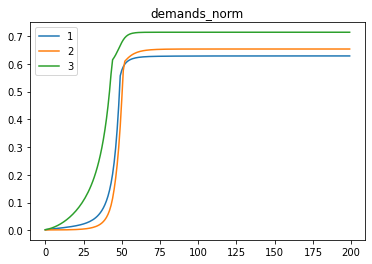

In [ ]:
num_iters = 200
learn_rate = 1
prices = np.array([15.1,16.1,12.1])
demands, demands_hist_cd = ne_oracle_cd(prices, valuations, budgets, num_iters, learn_rate, neighborsets)

demands0 = np.array([np.linalg.norm(demands[0]) for demands in demands_hist_cd])
demands1 = np.array([np.linalg.norm(demands[1]) for demands in demands_hist_cd])
demands2 = np.array([np.linalg.norm(demands[2]) for demands in demands_hist_cd])

fig, ax = plt.subplots()
ax.set_title('demands_norm')
ax.plot(np.arange(0, demands0.shape[0]), demands0, label = "1")
ax.plot(np.arange(0, demands1.shape[0]), demands1, label = "2")
ax.plot(np.arange(0, demands2.shape[0]), demands2, label = "3")
ax.legend()
fig.show()
# print(demands1)

# NE-Oracle Gradient Descent

In [ ]:
def ne_oracle_gd(valuations, budgets, prices_0, learning_rate_prices, learning_rate_demands,  num_iters_prices, num_iters_demands, neighborsets, util, decay = True):
    prices = np.copy(prices_0).clip(1)
    prices_hist = []
    demands_hist = []
    excess_demand_hist = []
    if util == "linear":
      ne_oracle = ne_oracle_linear
    elif util == "leontief":
      ne_oracle = ne_oracle_leontief
    elif util == "cd":
      ne_oracle = ne_oracle_cd
    for iter in range(1, num_iters_prices):
        if (not iter % 10):
            print(f" ----- Iteration {iter}/{num_iters_prices} ----- ")
        
        prices_hist.append(np.copy(prices))

        temp_demands, temp_demands_hist = ne_oracle(prices, valuations, budgets, num_iters_demands, learning_rate_demands, neighborsets)
        if util == "cd":
          demands = temp_demands
        else:
          demands = np.mean(np.array(temp_demands_hist[-25:]), axis = 0)
       
        demands_hist.append(np.copy(demands))
        excess_demand = np.sum(demands, axis = 0) - 1
        excess_demand_hist.append(np.linalg.norm(excess_demand))

        
        if (decay) :
            step_size = iter**(-1/2)*learning_rate_prices*excess_demand
            prices += step_size*((prices) > 0)
        else:
            step_size = learning_rate_prices*excess_demand
            prices += step_size*((prices) > 0)
        # print(prices)

        prices = prices.clip(min=0.01)
    print(f"excess demands: {excess_demand}")
    return (demands, prices, demands_hist, prices_hist, excess_demand_hist)

### Linear

In [ ]:
num_iters_prices = 300
num_iters_demands = 150
learning_rate_prices = 0.2
learning_rate_demands = 0.1
prices_0 = np.array([0.0,0.0,0.0])

util = "linear"
demands, prices, demands_hist, prices_hist, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, learning_rate_prices, learning_rate_demands,  
                                                                 num_iters_prices, num_iters_demands, neighborsets, util, decay = True)


print(excess_demands_hist[-1])
prices_norms = np.array([np.linalg.norm(prices) for prices in prices_hist])
excess_demands_hist = np.array(excess_demands_hist)
fig, ax = plt.subplots()
ax.set_title('Prices norm')
ax.plot(np.arange(0, prices_norms.shape[0]), prices_norms, label = "1")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title('Excess Demands norm')
ax.plot(np.arange(2, excess_demands_hist.shape[0]), excess_demands_hist[2:], label = "1")
ax.legend()
fig.show()

avg_prices = np.mean(np.array(prices_hist[20:]), axis=0)
avg_demands, _ = ne_oracle_linear(avg_prices, valuations, budgets, num_iters_demands, learning_rate_demands, neighborsets)

[3.89173016 2.44961861 0.8       ]
[3.7503088  2.30819725 7.04820895]
[4.10007331 2.74849702 6.93273889]
[4.36612949 3.02684076 6.83273889]
[4.58417697 3.23825809 6.74329617]
[4.77149707 3.4133766  6.66164652]
[4.93200603 3.55653961 6.58605362]
[5.07312162 3.67922406 6.51534294]
[5.20306205 3.79159788 6.44867628]
 ----- Iteration 10/300 ----- 
[5.32016856 3.89048339 6.38543072]
[5.42690751 3.97882213 6.32512846]
[5.52508374 4.05867949 6.26739343]
[5.61616983 4.13242319 6.21192341]
[5.70399911 4.2047148  6.15847116]
[5.78601488 4.27139499 6.10683138]
[5.86298563 4.33327699 6.05683138]
[5.93553451 4.39100836 6.00832426]
[6.00417397 4.44511326 5.96118381]
[6.06933068 4.49595098 5.91530066]
 ----- Iteration 20/300 ----- 
[6.13136362 4.54377085 5.8705793 ]
[6.19051521 4.58890583 5.82693572]
[6.24894142 4.63500861 5.78429558]
[6.23811901 4.67946211 5.81512006]
[6.22969046 4.72176161 5.84249898]
[6.27442761 4.76209953 5.81277703]
[6.26443007 4.8005362  5.84145411]
[6.25907845 4.83734888 5.864

In [ ]:
# print(prices_hist)
avg_prices = np.mean(np.array(prices_hist[20:]), axis=0)
avg_demands,_ = ne_oracle_linear(avg_prices, valuations, budgets, num_iters_demands, learning_rate_demands, neighborsets)


print(avg_prices)
print(avg_demands)
print(np.sum(avg_demands, axis=0)-1)

[3.51742858 3.49343613 3.27994923]
[[0.         2.31609106 0.        ]
 [1.48175284 0.         0.        ]
 [0.78677118 0.         2.22368363]]
[1.26852403 1.31609106 1.22368363]


## Leontief

In [ ]:
num_buyers = 3
num_goods = 3
valuations = np.random.rand(num_buyers, num_goods)*30 + 5
budgets = np.random.rand(num_buyers)*10 + 5

In [ ]:
neighborsets = np.array([[1, 1, 0],
                         [1, 1, 1],
                         [1, 0, 1]])

[3.4592327  5.95704168 4.90852364]
[3.73500074 6.32457585 5.26218155]
[3.95995305 6.58580109 5.50480641]
[4.12452246 6.79746093 5.69849881]
[4.25603951 6.97768022 5.85915502]
[4.36589531 7.12996449 6.00310703]
[4.45900561 7.26350859 6.13249919]
[4.54560755 7.38623331 6.24224801]
[4.62132539 7.49654121 6.34436306]
 ----- Iteration 10/500 ----- 
[4.68867486 7.59963528 6.4362221 ]
[4.75150318 7.69570878 6.51933636]
[4.81248307 7.7840032  6.59551496]
[4.86069199 7.86899082 6.6696612 ]
[4.91801416 7.94501697 6.73557444]
[4.96385666 8.01678354 6.80261989]
[5.00470725 8.08636536 6.8661125 ]
[5.04629018 8.15132237 6.92496453]
[5.08591825 8.21230403 6.98171339]
[5.12155374 8.27182484 7.03567658]
 ----- Iteration 20/500 ----- 
[5.15394127 8.33032234 7.08633371]
[5.18338983 8.38544707 7.13697552]
[5.21916499 8.43870413 7.18010324]
[5.24558884 8.48881925 7.22802175]
[5.2730636  8.53734917 7.27253282]
[5.29753333 8.58528811 7.31531033]
[5.32647445 8.63174301 7.35306016]
[5.35616971 8.67615962 7.388

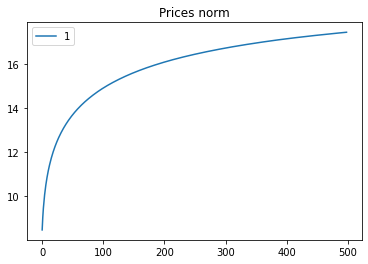

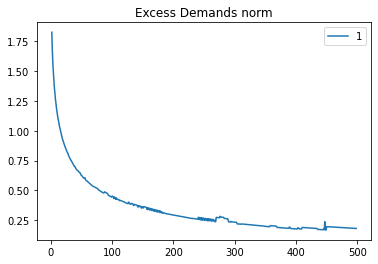

In [ ]:
num_iters_prices = 500
num_iters_demands = 200
learning_rate_prices = 0.5
learning_rate_demands = 3
prices_0 = np.array([5.0,5.0,5.0])

util = "leontief"
demands, prices, demands_hist, prices_hist, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, learning_rate_prices, learning_rate_demands,  
                                                                 num_iters_prices, num_iters_demands, neighborsets, util, decay = True)


print(excess_demands_hist[-1])
prices_norms = np.array([np.linalg.norm(prices) for prices in prices_hist])
excess_demands_hist = np.array(excess_demands_hist)
fig, ax = plt.subplots()
ax.set_title('Prices norm')
ax.plot(np.arange(0, prices_norms.shape[0]), prices_norms, label = "1")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title('Excess Demands norm')
ax.plot(np.arange(2, excess_demands_hist.shape[0]), excess_demands_hist[2:], label = "1")
ax.legend()
fig.show()

avg_prices = np.mean(np.array(prices_hist[20:]), axis=0)
avg_demands, _ = ne_oracle_linear(avg_prices, valuations, budgets, num_iters_demands, learning_rate_demands, neighborsets)

## cd

In [ ]:
neighborsets = [[1, 1, 0], [1, 1, 1], [1, 0, 1]]

In [ ]:
num_buyers = 3
num_goods = 3
valuations = np.random.rand(num_buyers, num_goods)*30 + 5
budgets = np.random.rand(num_buyers)*10 + 5

 ----- Iteration 10/400 ----- 
 ----- Iteration 20/400 ----- 
 ----- Iteration 30/400 ----- 
 ----- Iteration 40/400 ----- 
 ----- Iteration 50/400 ----- 
 ----- Iteration 60/400 ----- 
 ----- Iteration 70/400 ----- 
 ----- Iteration 80/400 ----- 
 ----- Iteration 90/400 ----- 
 ----- Iteration 100/400 ----- 
 ----- Iteration 110/400 ----- 
 ----- Iteration 120/400 ----- 
 ----- Iteration 130/400 ----- 
 ----- Iteration 140/400 ----- 
 ----- Iteration 150/400 ----- 
 ----- Iteration 160/400 ----- 
 ----- Iteration 170/400 ----- 
 ----- Iteration 180/400 ----- 
 ----- Iteration 190/400 ----- 
 ----- Iteration 200/400 ----- 
 ----- Iteration 210/400 ----- 
 ----- Iteration 220/400 ----- 
 ----- Iteration 230/400 ----- 
 ----- Iteration 240/400 ----- 
 ----- Iteration 250/400 ----- 
 ----- Iteration 260/400 ----- 
 ----- Iteration 270/400 ----- 
 ----- Iteration 280/400 ----- 
 ----- Iteration 290/400 ----- 
 ----- Iteration 300/400 ----- 
 ----- Iteration 310/400 ----- 
 ----- Iteration 

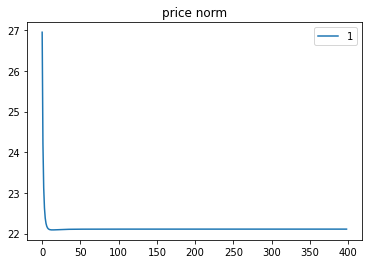

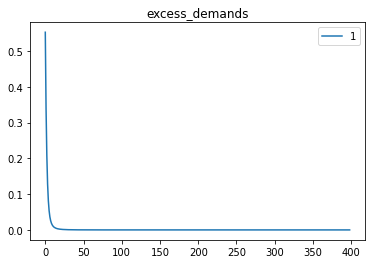

In [ ]:
num_iters_prices = 400
num_iters_demands = 200
learning_rate_prices = 8
#0.25 0.5
learning_rate_demands = 0.5
prices_0  = np.random.rand(num_goods) + 15

util = "cd"
demands, prices, demands_hist, prices_hist, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, learning_rate_prices, learning_rate_demands,  
                                                                 num_iters_prices, num_iters_demands, neighborsets, util, decay = True)

# print(demands)
# print(prices)

# print(excess_demands_hist)
# print(prices_hist)

prices_norms = np.array([np.linalg.norm(prices) for prices in prices_hist])
excess_demands_hist = np.array(excess_demands_hist)
fig, ax = plt.subplots()
ax.set_title('price norm')
ax.plot(np.arange(0, prices_norms.shape[0]), prices_norms, label = "1")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title('excess_demands')
ax.plot(np.arange(0, excess_demands_hist.shape[0]), excess_demands_hist, label = "1")
ax.legend()
fig.show()

In [ ]:
print(excess_demands_hist[-1])

6.266393447894177e-10


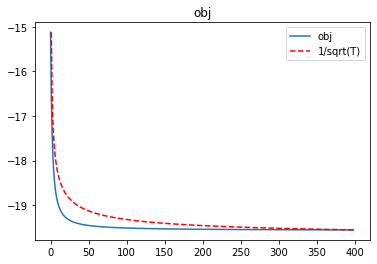

In [ ]:
def get_average_obj_static(obj_func, prices_hist, demands_hist, budgets, valuations, neighborsets):
    obj_avg_hist = []
    for i in range(0, len(demands_hist)):
        x = np.mean(np.array(demands_hist[:i+1]).clip(min = 0), axis = 0)
        p = np.mean(np.array(prices_hist[:i+1]).clip(min = 0), axis = 0)
        obj = obj_func(p, x, budgets, valuations, neighborsets)
        obj_avg_hist.append(obj)
    return obj_avg_hist

obj_func = get_cd_obj
objective_values = get_average_obj_static(obj_func, prices_hist, demands_hist, budgets, valuations, neighborsets)


# objective_values = []
# for x, p in zip(demands_hist, prices_hist):
#   obj = get_leontief_obj(p, x, budgets, valuations, neighborsets)
#   objective_values.append(obj)


x_cd = np.linspace(1, num_iters_prices, num_iters_prices)

n = ((num_iters_prices)**(1/2) * objective_values[-1] - objective_values[0])/((num_iters_prices)**(1/2) -1)
m = objective_values[0] - n

fig, ax = plt.subplots()
ax.set_title('obj')
ax.plot(np.arange(0, len(objective_values)), objective_values, label = "obj")
ax.plot(x_cd, m*(x_cd**(-1/2))  + n, color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.legend()
fig.show()

# Experiment Func

In [ ]:
def get_average_obj_static(obj_func, prices_hist, demands_hist, budgets, valuations, neighborsets):
    obj_avg_hist = []
    for i in range(0, len(demands_hist)):
        x = np.mean(np.array(demands_hist[:i+1]).clip(min = 0), axis = 0)
        p = np.mean(np.array(prices_hist[:i+1]).clip(min = 0), axis = 0)
        obj = obj_func(p, x, budgets, valuations, neighborsets)
        obj_avg_hist.append(obj)
    return obj_avg_hist

In [ ]:
def run_test(num_buyers, num_goods,  num_experiments, learning_rate_linear, learning_rate_leontief, learning_rate_cd, num_iters_linear, num_iters_cd, num_iters_leontief, neighborsets):
    
    prices_hist_neogd_linear_all_low = []
    demands_hist_neogd_linear_all_low = []
    obj_hist_neogd_linear_all_low = []
    excess_demands_linear_all = []

    prices_hist_neogd_cd_all_low = []
    demands_hist_neogd_cd_all_low = []
    obj_hist_neogd_cd_all_low = []
    excess_demands_cd_all = []

    prices_hist_neogd_leontief_all_low = []
    demands_hist_neogd_leontief_all_low = []
    obj_hist_neogd_leontief_all_low = []
    excess_demands_leontief_all = []
  
  

    for experiment_num in range(num_experiments):

        print(f"************* Experiment: {experiment_num + 1}/{num_experiments} *************")

        # Initialize random market parameters
        valuations = np.random.rand(num_buyers, num_goods)*30 + 5
        budgets = np.random.rand(num_buyers)*10 + 5
        
        
        print(f"****** Market Parameters ******\nval = {valuations}\n budgets = {budgets}\n")
        print(f"*******************************")
        
        print(f"------------ Low Initial Prices ------------")

        print(f"------ Linear Fisher Market ------\n")
        prices_0  = np.random.rand(num_goods) + 15

        demands_neogd, prices_neogd, demands_hist_neogd, prices_hist_neogd, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, 
                                                                                                               learning_rate_linear[0], learning_rate_linear[1],  
                                                                 num_iters_linear[0], num_iters_linear[1], neighborsets, "linear", decay = False)
        
        prices_hist_neogd_linear_all_low.append(prices_neogd)
        demands_hist_neogd_linear_all_low.append(demands_neogd)
        excess_demands_linear_all.append(excess_demands_hist)
        obj_func = get_linear_obj
        objective_values = get_average_obj_static(obj_func, prices_hist_neogd, demands_hist_neogd, budgets, valuations, neighborsets)
        # objective_values = []
        # for x, p in zip(demands_hist_neogd, prices_hist_neogd):
        #   obj = get_leontief_obj(p, x, budgets, valuations, neighborsets)
        #   objective_values.append(obj)
        obj_hist_neogd_linear_all_low.append(objective_values)
        
        
        print(f"------ Cobb-Douglas Fisher Market ------")
        prices_0  = np.random.rand(num_goods) + 15
        

        demands_neogd, prices_neogd, demands_hist_neogd, prices_hist_neogd, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, 
                                                                                                               learning_rate_cd[0], learning_rate_cd[1],  
                                                                 num_iters_cd[0], num_iters_cd[1], neighborsets, "cd", decay = False)
        prices_hist_neogd_cd_all_low.append(prices_neogd)
        demands_hist_neogd_cd_all_low.append(demands_neogd)
        excess_demands_cd_all.append(excess_demands_hist)
        obj_func = get_cd_obj
        objective_values = get_average_obj_static(obj_func, prices_hist_neogd, demands_hist_neogd, budgets, valuations, neighborsets)
        # objective_values = []
        # for x, p in zip(demands_hist_neogd, prices_hist_neogd):
        #   obj = get_leontief_obj(p, x, budgets, valuations, neighborsets)
        #   objective_values.append(obj)
        obj_hist_neogd_cd_all_low.append(objective_values)
        

    
        print(f"------ Leontief Fisher Market ------")
        prices_0  = np.random.rand(num_goods) + 15


        demands_neogd, prices_neogd, demands_hist_neogd, prices_hist_neogd, excess_demands_hist = ne_oracle_gd(valuations, budgets, prices_0, 
                                                                                                               learning_rate_linear[0], learning_rate_leontief[1],  
                                                                 num_iters_leontief[0], num_iters_leontief[1], neighborsets, "leontief", decay = False)
        prices_hist_neogd_leontief_all_low.append(prices_neogd)
        demands_hist_neogd_leontief_all_low.append(demands_neogd)
        excess_demands_leontief_all.append(excess_demands_hist)
        obj_func = get_leontief_obj
        objective_values = get_average_obj_static(obj_func, prices_hist_neogd, demands_hist_neogd, budgets, valuations, neighborsets)
        # objective_values = []
        # for x, p in zip(demands_hist_neogd, prices_hist_neogd):
        #   obj = get_leontief_obj(p, x, budgets, valuations, neighborsets)
        #   objective_values.append(obj)
        obj_hist_neogd_leontief_all_low.append(objective_values)        
        
        
        
    return (prices_hist_neogd_linear_all_low,
            demands_hist_neogd_linear_all_low,
            obj_hist_neogd_linear_all_low,
            excess_demands_linear_all,
            prices_hist_neogd_cd_all_low,
            demands_hist_neogd_cd_all_low,
            obj_hist_neogd_cd_all_low, 
            excess_demands_cd_all,
            prices_hist_neogd_leontief_all_low,
            demands_hist_neogd_leontief_all_low,
            obj_hist_neogd_leontief_all_low, 
            excess_demands_leontief_all)

# Experiment Code

In [ ]:
import pandas as pd

In [ ]:
num_experiments = 50
num_buyers =  3
num_goods = 3
learning_rate_linear = [2, 0.2]
learning_rate_cd = [8, 0.5]
learning_rate_leontief = [5, 3]
num_iters_linear = [400, 100]
num_iters_cd = [400, 200]
num_iters_leontief = [400,100]
neighborsets =  np.array([[1, 1, 0], [1, 1, 1], [1, 0, 1] ])

(prices_hist_neogd_linear_all_low,
            demands_hist_neogd_linear_all_low,
            obj_hist_neogd_linear_all_low,
            excess_demands_linear_all,
            prices_hist_neogd_cd_all_low,
            demands_hist_neogd_cd_all_low,
            obj_hist_neogd_cd_all_low, 
            excess_demands_cd_all,
            prices_hist_neogd_leontief_all_low,
            demands_hist_neogd_leontief_all_low,
            obj_hist_neogd_leontief_all_low, 
            excess_demands_leontief_all) = run_test(num_buyers, num_goods, num_experiments, learning_rate_linear, learning_rate_leontief, learning_rate_cd, 
                                                    num_iters_linear, num_iters_cd, num_iters_leontief, neighborsets)





Streaming output truncated to the last 5000 lines.
 ----- Iteration 30/400 ----- 
 ----- Iteration 40/400 ----- 
 ----- Iteration 50/400 ----- 
 ----- Iteration 60/400 ----- 
 ----- Iteration 70/400 ----- 
 ----- Iteration 80/400 ----- 
 ----- Iteration 90/400 ----- 
 ----- Iteration 100/400 ----- 
 ----- Iteration 110/400 ----- 
 ----- Iteration 120/400 ----- 
 ----- Iteration 130/400 ----- 
 ----- Iteration 140/400 ----- 
 ----- Iteration 150/400 ----- 
 ----- Iteration 160/400 ----- 
 ----- Iteration 170/400 ----- 
 ----- Iteration 180/400 ----- 
 ----- Iteration 190/400 ----- 
 ----- Iteration 200/400 ----- 
 ----- Iteration 210/400 ----- 
 ----- Iteration 220/400 ----- 
 ----- Iteration 230/400 ----- 
 ----- Iteration 240/400 ----- 
 ----- Iteration 250/400 ----- 
 ----- Iteration 260/400 ----- 
 ----- Iteration 270/400 ----- 
 ----- Iteration 280/400 ----- 
 ----- Iteration 290/400 ----- 
 ----- Iteration 300/400 ----- 
 ----- Iteration 310/400 ----- 
 ----- Iteration 320/400 ---

In [ ]:
print(excess_demands_linear_all)
print(len(obj_hist_neogd_linear_all_low[0]))
print(len(excess_demands_linear_all[0]))

[[0.6294839908360592, 0.6066775129544411, 0.5383512944293348, 1.2318519855943957, 0.5353598565572637, 0.485821199551932, 0.39975079249079115, 0.37172747710611287, 1.4079164078823752, 0.5477110226949548, 0.39911055830596565, 0.33934182217645903, 1.4418735196124235, 0.6496353696157702, 0.43991424305962146, 0.35000959235383183, 0.2094552935563712, 0.30525703149692285, 1.4905216610974914, 0.6802778142429736, 0.4381570439460647, 0.3341735147099127, 1.5221175919514878, 0.7159416581505011, 0.4551513607322869, 0.34591832003575357, 1.507324660437668, 0.7205657658850714, 0.4569096953447445, 0.3467742710609621, 1.507259116291241, 0.721580067844477, 0.4572022947065538, 0.34680315329830147, 1.5077235674076865, 0.721920529139061, 0.45728630686447785, 0.34679008844700215, 1.5079463122215717, 0.7220510312869908, 0.45731708581487596, 0.3467830285712315, 1.508037429010291, 0.7221023878950734, 0.45732907204461065, 0.34678009716620545, 1.5080736743356322, 0.7221226793690653, 0.4573337967967282, 0.34677892

In [ ]:
# # # Save data
obj_hist_neogd_linear_all_low = np.array(obj_hist_neogd_linear_all_low)
obj_hist_neogd_cd_all_low = np.array(obj_hist_neogd_cd_all_low)
obj_hist_neogd_leontief_all_low = np.array(obj_hist_neogd_leontief_all_low)

excess_demands_linear_all = np.array(excess_demands_linear_all)
excess_demands_cd_all = np.array(excess_demands_cd_all)
excess_demands_leontief_all = np.array(excess_demands_leontief_all)

# obj_hist_neogd_linear_low.to_csv("data/obj/obj_hist_neogd_linear_low.csv")
# obj_hist_neogd_cd_low.to_csv("data/obj/obj_hist_neogd_cd_low.csv")
# obj_hist_neogd_leontief_low.to_csv("data/obj/obj_hist_neogd_leontief_low.csv")

prices_hist_neogd_linear_all_low = np.array(prices_hist_neogd_linear_all_low)
prices_hist_neogd_cd_all_low = np.array(prices_hist_neogd_cd_all_low)
prices_hist_neogd_leontief_all_low = np.array(prices_hist_neogd_leontief_all_low)

# prices_neogd_linear_low =  pd.DataFrame(prices_hist_neogd_linear_all_low)
# prices_neogd_cd_low =  pd.DataFrame(prices_hist_neogd_cd_all_low)
# prices_neogd_leontief_low =  pd.DataFrame( prices_hist_neogd_leontief_all_low)


# prices_neogd_linear_low.to_csv("data/prices/prices_neogd_linear_low.csv")
# prices_neogd_cd_low.to_csv("data/prices/prices_neogd_cd_low.csv")
# prices_neogd_leontief_low.to_csv("data/prices/prices_neogd_leontief_low.csv")


#%%
obj_neogd_linear_low = np.mean(obj_hist_neogd_linear_all_low, axis = 0)
obj_neogd_cd_low = np.mean(obj_hist_neogd_cd_all_low, axis = 0)
obj_neogd_leontief_low = np.mean(obj_hist_neogd_leontief_all_low, axis = 0)


excess_demands_linear = np.mean(excess_demands_linear_all, axis = 0)
excess_demands_cd = np.mean(excess_demands_cd_all, axis = 0)
excess_demands_leontief = np.mean(excess_demands_leontief_all, axis = 0)

# obj_neogd_leontief_low = obj_neogd_leontief_low[:-200]


num_iters_linear = len(obj_neogd_linear_low)
num_iters_cd = len(obj_neogd_cd_low)
num_iters_leontief = len(obj_neogd_leontief_low)
x_linear = np.linspace(1, num_iters_linear, num_iters_linear)
x_cd = np.linspace(1, num_iters_cd, num_iters_cd)
x_leontief = np.linspace(1, num_iters_leontief, num_iters_leontief)



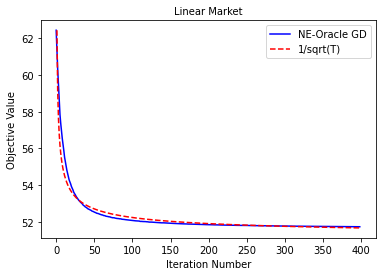

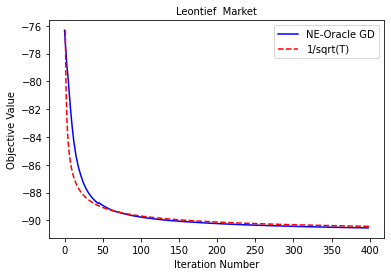

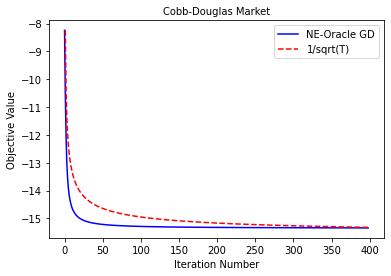

In [ ]:
n = ((num_iters_linear)**(1/2) * obj_neogd_linear_low[-1] - obj_neogd_linear_low[0])/((num_iters_prices)**(1/2) -1)
m = obj_neogd_linear_low[0] - n

fig, ax = plt.subplots()
ax.set_title('linear obj')
ax.plot(np.arange(0, obj_neogd_linear_low.shape[0]), obj_neogd_linear_low, label = "NE-Oracle GD", color = "b")
ax.plot(x_linear, m*(x_leontief**(-1/2)) + n, color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Linear Market", fontsize = "medium")
ax.legend()
ax.set(xlabel='Iteration Number', ylabel='Objective Value')


n = ((num_iters_leontief)**(1/2) * obj_neogd_leontief_low[-1] - obj_neogd_leontief_low[0])/((num_iters_prices)**(1/2) -1)
m = obj_neogd_leontief_low[0] - n

fig, ax = plt.subplots()
ax.set_title('leontief obj')
ax.plot(np.arange(0, obj_neogd_leontief_low.shape[0]), obj_neogd_leontief_low, label = "NE-Oracle GD", color = "b")
ax.plot(x_leontief, m*(x_leontief**(-1/2)) +n, color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Leontief  Market", fontsize = "medium")
ax.set(xlabel='Iteration Number', ylabel='Objective Value')
ax.legend()


n = ((num_iters_cd)**(1/2) * obj_neogd_cd_low[-1] - obj_neogd_cd_low[0])/((num_iters_prices)**(1/2) -1)
m = obj_neogd_cd_low[0] - n

fig, ax = plt.subplots()
ax.set_title('cd obj')
ax.plot(np.arange(0, obj_neogd_cd_low.shape[0]), obj_neogd_cd_low, label = "NE-Oracle GD", color = "b")
ax.plot(x_cd, m*(x_cd**(-1/2)) + n, color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Cobb-Douglas Market", fontsize = "medium")
ax.set(xlabel='Iteration Number', ylabel='Objective Value')
ax.legend()
fig.show()


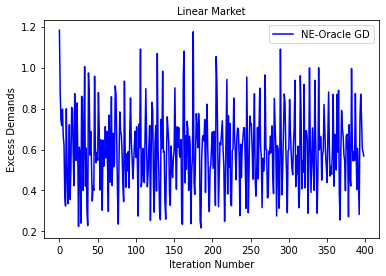

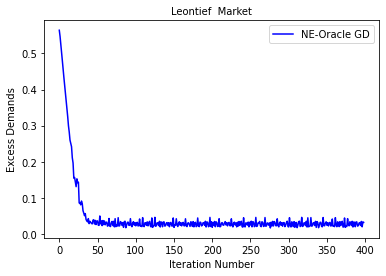

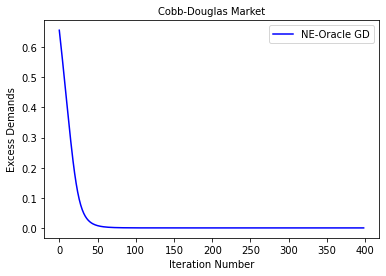

In [ ]:
fig, ax = plt.subplots()
ax.set_title('linear obj')
ax.plot(np.arange(0, excess_demands_linear.shape[0]), excess_demands_linear, label = "NE-Oracle GD", color = "b")
# ax.plot(x_linear, (obj_neogd_linear_low[0] - obj_neogd_linear_low[-1])*(x_leontief**(-1/2)) + obj_neogd_linear_low[-1], color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Linear Market", fontsize = "medium")
ax.legend()
ax.set(xlabel='Iteration Number', ylabel='Excess Demands')


fig, ax = plt.subplots()
ax.set_title('leontief obj')
ax.plot(np.arange(0, excess_demands_leontief.shape[0]), excess_demands_leontief, label = "NE-Oracle GD", color = "b")
# ax.plot(x_leontief, (obj_neogd_leontief_low[0] - obj_neogd_leontief_low[-1])*(x_leontief**(-1/2)) + obj_neogd_leontief_low[-1], color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Leontief  Market", fontsize = "medium")
ax.set(xlabel='Iteration Number', ylabel='Excess Demands')
ax.legend()



fig, ax = plt.subplots()
ax.set_title('cd obj')
ax.plot(np.arange(0, excess_demands_cd.shape[0]), excess_demands_cd, label = "NE-Oracle GD", color = "b")
# ax.plot(x_cd, (obj_neogd_cd_low[0] - obj_neogd_cd_low[-1])*(x_cd**(-1/2)) + obj_neogd_cd_low[-1], color='red', linestyle='dashed', label = "1/sqrt(T)")
ax.set_title("Cobb-Douglas Market", fontsize = "medium")
ax.set(xlabel='Iteration Number', ylabel='Excess Demands')
ax.legend()
fig.show()